In [2]:
%matplotlib inline

import shapely.geometry, shapely.wkt
from shapely.geometry.point import Point
from shapely.geometry.polygon import LinearRing
from shapely.geometry.linestring import LineString
from shapely.geometry.polygon import Polygon
import shapely as sl
import fiona
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import pylab

from utils.shapely_plot import draw

pylab.rcParams['figure.figsize'] = (17.0, 15.0)


In [3]:
shp_path = r'../data/OpenStreetMap/australia-oceania-latest-5030073410-water-lines.shp'


In [4]:
lengths = []
with fiona.collection(shp_path, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])
        lengths.append(geom.length)


KeyboardInterrupt: 

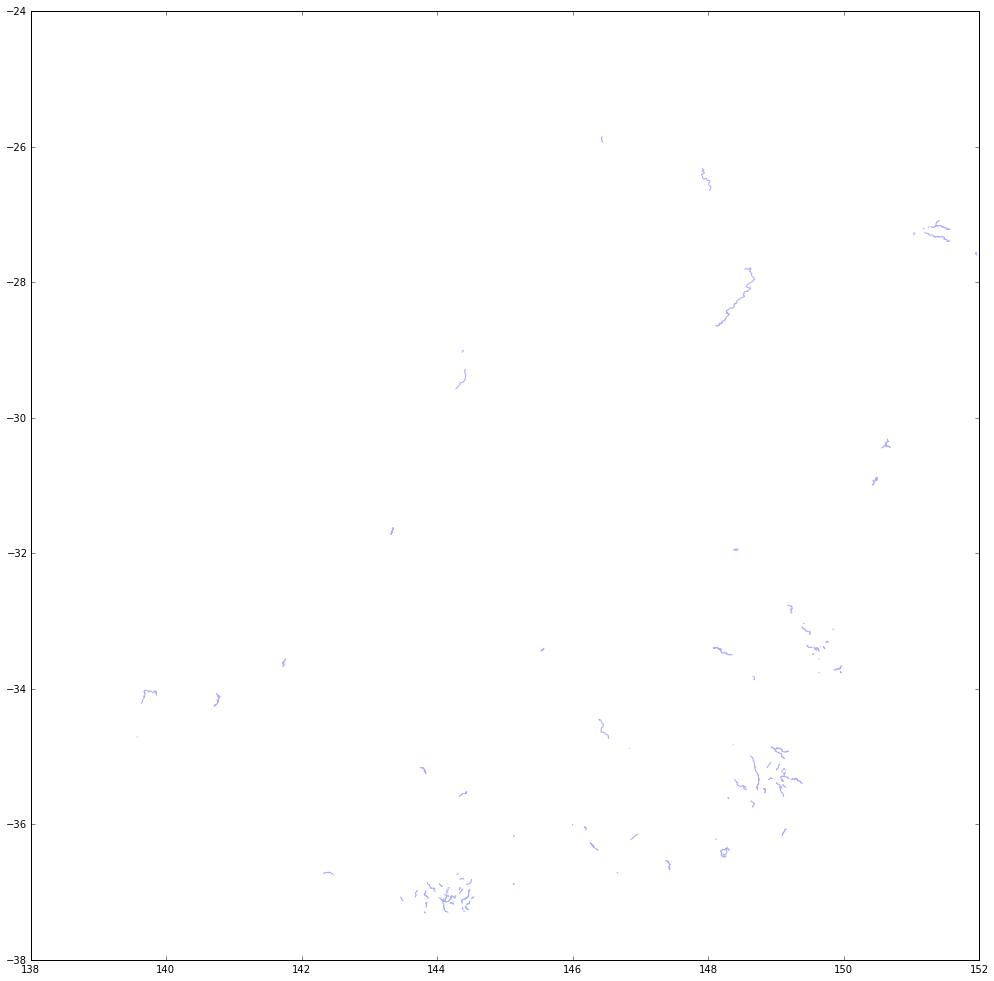

In [5]:
fig = plt.figure(figsize=(17, 17))
ax = plt.axes()
ax.set_aspect('equal', 'datalim')

with fiona.collection(shp_path, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])
        draw(geom, outline='#aaaaff', alpha=0.5)
            
plt.show()

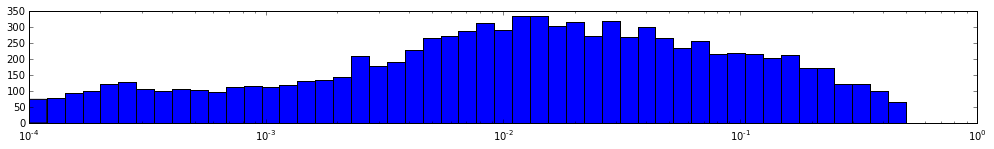

In [6]:
fig = plt.figure(figsize=(17, 2))
ax = plt.axes()

ax.set_xscale('log')
bins = 10 ** np.linspace(np.log10(0.0001), np.log10(0.5), 50)

#bins = 100


_ = plt.hist(lengths, bins)

In [7]:
def pair(list):
    '''Iterate over pairs in a list -> pair of points '''
    for i in range(1, len(list)):
        yield list[i-1], list[i]

for seg_start, seg_end in pair(geom.coords):
    line_start = Point(seg_start)
    line_end = Point(seg_end)
    segment = LineString([line_start.coords[0],line_end.coords[0]])

    print segment    

LINESTRING (150.6029044 -29.5390386, 150.6023251 -29.5395613)
LINESTRING (150.6023251 -29.5395613, 150.6014893 -29.5397144)
LINESTRING (150.6014893 -29.5397144, 150.5999433 -29.5398787)
LINESTRING (150.5999433 -29.5398787, 150.59857 -29.5398413)
LINESTRING (150.59857 -29.5398413, 150.5974327 -29.5394493)
LINESTRING (150.5974327 -29.5394493, 150.5964682 -29.5399011)
LINESTRING (150.5964682 -29.5399011, 150.5938718 -29.5399197)
LINESTRING (150.5938718 -29.5399197, 150.5924116 -29.54014)
LINESTRING (150.5924116 -29.54014, 150.5906961 -29.5411145)
LINESTRING (150.5906961 -29.5411145, 150.5895803 -29.5415252)
LINESTRING (150.5895803 -29.5415252, 150.5881845 -29.5415775)
LINESTRING (150.5881845 -29.5415775, 150.5875204 -29.5419172)
LINESTRING (150.5875204 -29.5419172, 150.5859539 -29.5441014)
LINESTRING (150.5859539 -29.5441014, 150.5854808 -29.5443777)
LINESTRING (150.5854808 -29.5443777, 150.5848156 -29.544471)
LINESTRING (150.5848156 -29.544471, 150.58413 -29.544176)
LINESTRING (150.58413

0.106613844241


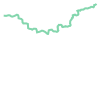

In [8]:
# get first geom

shp_path = r'../data/OpenStreetMap/australia-oceania-latest-5030073410-water-lines.shp'
    
g = None
with fiona.collection(shp_path, "r") as input:
    for f in input:
        g = sl.geometry.shape(f['geometry'])
        break

print(g.length)
g

In [9]:
def getDistance(coord1, coord2):
    return Point(coord1).distance(Point(coord2))

def explodeLineString(lineString, segmentLength):
    length = lineString.length
    coords = lineString.coords
  
    # first point
    pt1 = coords[0]
    ipt2 = 1
    
    currentLength = 0.0
    
    segments = []
    segmentId = 0
  
    while currentLength < length and ipt2 < len(coords):
        segmentPoints = []
        segmentPoints.append(pt1)
        
        currentSegmentLength = 0.0
        
        # print('ipt2:{0}, N:{1} Lc:{2}, L:{3}'
        #      .format(ipt2, len(coords), currentLength, length))
        
        while currentSegmentLength < segmentLength:
            if ipt2 == len(coords):
                break
                
            pt2 = coords[ipt2]
            distance = getDistance(pt1, pt2)
      
            # print('d:{0}, Lc: {1} Ls: {2} ipt2: {3}'
            #      .format(distance, currentSegmentLength, segmentLength, ipt2))

            if currentSegmentLength + distance > segmentLength: # split
                # hypotenuse lengths
                h1 = segmentLength - currentSegmentLength # short
                h2 = distance # long
        
                # cathetus2
                dx2 = pt2[0] - pt1[0]
                dy2 = pt2[1] - pt1[1]

                # cathetus1
                ratio = h1 / h2
                x1 = pt1[0] + dx2 * ratio
                y1 = pt1[1] + dy2 * ratio

                currentSegmentLength += h1
        
                pt1 = [x1, y1]
                segmentPoints.append(pt1)
            else: # next
                currentSegmentLength += distance

                segmentPoints.append(pt2)
                pt1 = pt2
                ipt2 += 1
        
        currentLength += currentSegmentLength
        segmentId += 1
    
        segments.append(LineString(segmentPoints))
        
    return segments

In [10]:
print(getDistance(g.coords[0], g.coords[1]))
print(g.length)

0.000502866682127
0.106613844241


In [11]:
segments = explodeLineString(g, 0.02)

In [12]:
len(segments)

6

In [13]:
shp_path = r'../data/OpenStreetMap/australia-oceania-latest-5030073410-water-lines.shp'
    
lengths_exploded = []
with fiona.collection(shp_path, "r") as input:
    for f in input:
        segments = explodeLineString(sl.geometry.shape(f['geometry']), 0.02)
        for s in segments:
            lengths_exploded.append(s.length)

In [14]:
print('Total length: ' + str(sum(lengths)))

Total length: 576.87027753


In [15]:
print(len(lengths))
print(len(lengths_exploded))

9576
34936


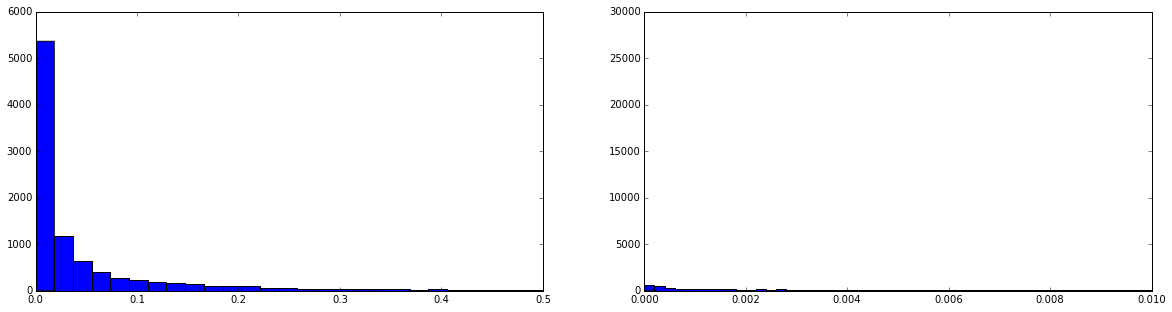

In [16]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.set_xlim(0, 0.5)
_ = ax1.hist(lengths, 100)

ax2.set_xlim(0, 0.01)
_ = ax2.hist(lengths_exploded, 100)
plt.show()


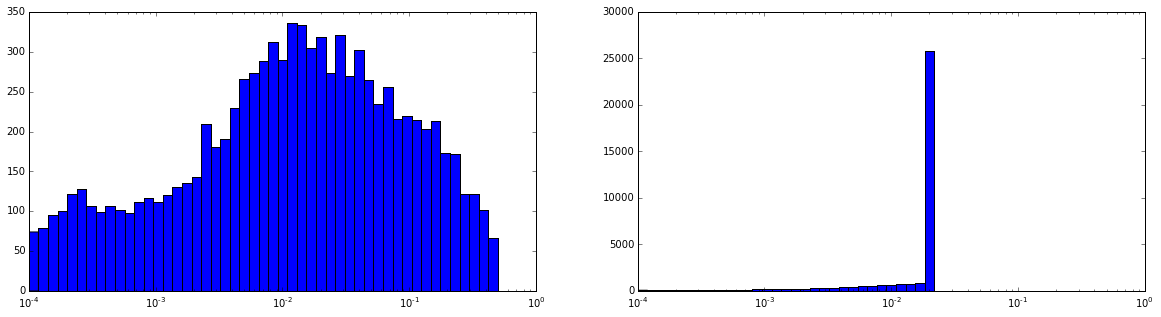

In [18]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

bins = 10 ** np.linspace(np.log10(0.0001), np.log10(0.5), 50)
_ = ax1.hist(lengths, bins)
ax1.set_xscale('log')

bins = 10 ** np.linspace(np.log10(0.0001), np.log10(0.5), 50)
_ = ax2.hist(lengths_exploded, bins)
ax2.set_xscale('log')

plt.show()



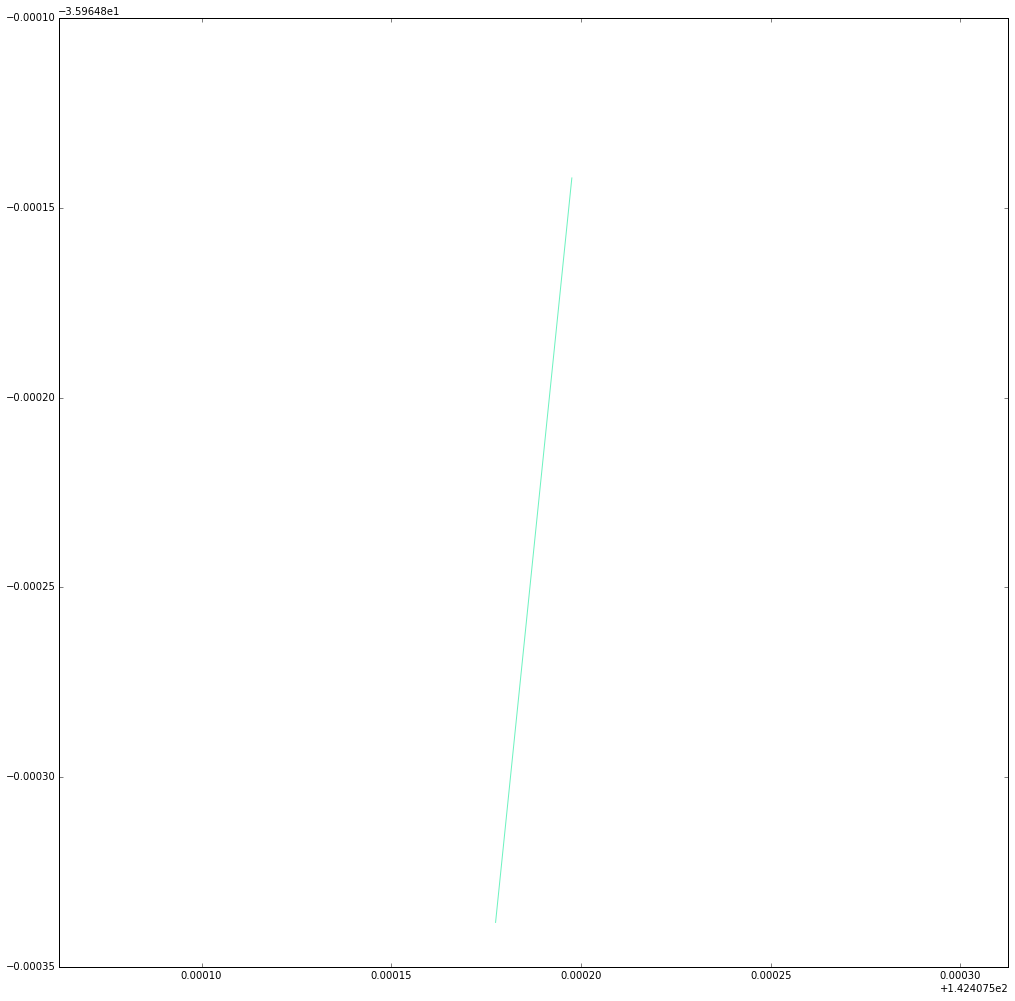

In [17]:
fig = plt.figure(figsize=(17, 17))
ax = plt.axes()
ax.set_aspect('equal', 'datalim')

# original
# draw(g, outline='#000000')

cmap = matplotlib.colors.ListedColormap (np.random.rand ( 256,3))

# segments
for (i, s) in enumerate(segments):
    draw(s, outline=cmap.colors[i])
            
plt.show()

In [19]:
from shapely.geometry import mapping

# take polylines and split them into segments of a given length

shp_path = r'../data/OpenStreetMap\australia-oceania-latest-5030073410-water-lines.shp'
shp_segments_path = r'../data/OpenStreetMap\australia-oceania-latest-5030073410-water-lines-segments.shp'

step = 0.02 # degrees

with fiona.collection(shp_path, "r") as input:
    schema = input.schema
    schema['properties']['segment'] = 'int'
    
    with fiona.open(shp_segments_path, 'w', 'ESRI Shapefile', schema) as output:
        for f in input:
            geom = sl.geometry.shape(f['geometry'])
            segments = explodeLineString(geom, step)
            
            for (i, s) in enumerate(segments):
                properties = f['properties']
                properties['segment'] = i
                output.write({'geometry': mapping(s), 'properties': properties})
    